In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import math
from itertools import product
from xgboost import XGBRegressor, plot_importance
import gc

## Read Data

In [2]:
train_df = pd.read_csv("./sales_train.csv")
print(train_df.info())
print('\n\n')
print(train_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None



         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


In [3]:
test_df = pd.read_csv('./test.csv')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None


In [4]:
items_df = pd.read_csv('./items.csv')
print(items_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None


## Clean Data

In [5]:
# Remove outliers
train_df = train_df[(train_df['item_price'] < 200_000) & (train_df['item_cnt_day'] < 1000)]
# clip item count to positive
train_df.loc[train_df['item_cnt_day'] < 1, 'item_cnt_day'] = 0
# remove items with negative price
train_df = train_df[train_df['item_price']>0]

## Plot Data

In [6]:
# flierprops = dict(marker='o', linestyle='none')
# plt.figure(figsize=(10,4))
# sns.boxplot(x=train_df['item_cnt_day'], flierprops=flierprops)

# plt.figure(figsize=(10,4))
# plt.xlim(0, train_df['item_price'].max() * 1.1)
# sns.boxplot(x=train_df['item_price'], flierprops=flierprops)

## Generate rows for every combination of shop, item and month

In [7]:
all_data = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = train_df[train_df['date_block_num']==i]
    all_data.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype=np.int16))

all_data_df = pd.DataFrame(np.vstack(all_data), columns=cols)
s_types = {'date_block_num': np.uint8, 'shop_id': np.uint8, 'item_id': np.uint16}
all_data_df = all_data_df.astype(s_types)
all_data_df.sort_values(cols, inplace=True)
print(all_data_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 139255 to 10770465
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   date_block_num  uint8 
 1   shop_id         uint8 
 2   item_id         uint16
dtypes: uint16(1), uint8(2)
memory usage: 124.9 MB
None


## Aggregate data on a monthly basis and add features

In [8]:
month_df = train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum'})

month_df.columns = ['item_cnt_month']
month_df.reset_index(inplace=True)

matrix = pd.merge(all_data_df, month_df, on = cols, how='left')
matrix['item_cnt_month'].fillna(0, inplace=True)
print(matrix.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913804 entries, 0 to 10913803
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  uint8  
 1   shop_id         uint8  
 2   item_id         uint16 
 3   item_cnt_month  float64
dtypes: float64(1), uint16(1), uint8(2)
memory usage: 208.2 MB
None


## Merge aggregated and generated data

In [9]:
test_df['date_block_num'] = 34

test_matrix = pd.concat([matrix, test_df.drop(columns=['ID'])], ignore_index=True, sort=False, keys=["date_block_num", "shop_id", "item_id"])

test_matrix.fillna(0, inplace=True)

# test_matrix = test_matrix.astype(small_types)

test_matrix = pd.merge(test_matrix, items_df.drop(columns=['item_name']), how='left', on='item_id')
test_matrix['item_category_id'] = test_matrix['item_category_id'].astype(np.uint8)

print(test_matrix.info())
print('\n\n\n')
print(test_matrix.loc[test_matrix['date_block_num']==33].info())
print('\n\n\n')
print(test_matrix.loc[(test_matrix['date_block_num']==33) & (test_matrix['shop_id'] == 36)])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_cnt_month    float64
 4   item_category_id  uint8  
dtypes: float64(1), int64(3), uint8(1)
memory usage: 435.1 MB
None




<class 'pandas.core.frame.DataFrame'>
Int64Index: 238172 entries, 10675632 to 10913803
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date_block_num    238172 non-null  int64  
 1   shop_id           238172 non-null  int64  
 2   item_id           238172 non-null  int64  
 3   item_cnt_month    238172 non-null  float64
 4   item_category_id  238172 non-null  uint8  
dtypes: float64(1), int64(3), uint8(1)
memory usage: 9.3 MB
None




          date_block_num  shop_id  item_id  item_cnt_month  item_category_

In [139]:
matrix = test_matrix.copy()

avg_price_df = train_df.groupby(['date_block_num', 'item_id']).agg({'item_price':'mean', 'item_cnt_day': 'sum'})
avg_price_df.columns = ['avg_item_month_price', 'all_item_cnt_month']
avg_price_df.reset_index(inplace=True)

matrix = pd.merge(matrix, avg_price_df, on = ['date_block_num', 'item_id'], how='left')
matrix.reset_index(inplace=True)
matrix.drop(columns=['index'], inplace=True)
matrix['all_item_cnt_month'].fillna(0, inplace=True)

avg_price_df = train_df.groupby(['item_id']).agg({'item_price':'mean'})
avg_price_df.columns = ['avg_item_price']
avg_price_df.reset_index(inplace=True)

matrix = pd.merge(matrix, avg_price_df, on = ['item_id'], how='left')
matrix.reset_index(inplace=True)
matrix.drop(columns=['index'], inplace=True)
matrix.fillna(0, inplace=True)


shop_stats_df = train_df.groupby(['date_block_num', 'shop_id']).agg({'item_price':'mean', 'item_cnt_day':'sum'})
shop_stats_df.columns = ['avg_monthly_shop_price', 'shop_item_count']
shop_stats_df.reset_index(inplace=True)

matrix = pd.merge(matrix, shop_stats_df, on = ['date_block_num', 'shop_id'], how='left')
matrix.reset_index(inplace=True)
matrix.drop(columns=['index'], inplace=True)
matrix.fillna(0, inplace=True)

matrix['shop_month_revenue'] = matrix['avg_monthly_shop_price'] * matrix['shop_item_count']

matrix['month'] = matrix['date_block_num'] % 12

small_types = {'date_block_num': np.uint8, 'shop_id': np.uint8, 'item_id': np.uint16, 'item_cnt_month': np.uint16,  'shop_month_revenue': np.float32, 'month': np.uint8, 'avg_item_month_price': np.float32, 'avg_item_price': np.float32, 'all_item_cnt_month': np.uint16, 'avg_monthly_shop_price': np.float32, 'shop_item_count': np.uint32}

matrix = matrix.astype(small_types)


print(matrix.info())
print('\n\n\n')
print(matrix.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Data columns (total 13 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   date_block_num          uint8  
 1   shop_id                 uint8  
 2   item_id                 uint16 
 3   item_cnt_month          uint16 
 4   item_category_id        uint8  
 5   avg_item_month_price    float32
 6   all_item_cnt_month      uint16 
 7   avg_item_price          float32
 8   avg_monthly_shop_price  float32
 9   shop_item_count         uint32 
 10  pct_item_sold_in_shop   float16
 11  shop_month_revenue      float32
 12  month                   uint8  
dtypes: float16(1), float32(4), uint16(3), uint32(1), uint8(4)
memory usage: 339.6 MB
None




   date_block_num  shop_id  item_id  item_cnt_month  item_category_id  \
0               0        0       19               0                40   
1               0        0       27               0                19   
2               

In [140]:
def add_lagged_column(df, lags, column, fill_val, col_type):
    t = df[['date_block_num', 'shop_id', 'item_id', column]]
    for lag_amount in lags:
        tmp = t.copy()
        
        tmp['date_block_num'] = tmp['date_block_num'] + lag_amount
        
        lag_col_name = f'{column}_lag_{lag_amount}'
        tmp.rename(columns = {column: lag_col_name}, inplace=True)
        
        df = pd.merge(df, tmp, on=['date_block_num', 'shop_id', 'item_id'], how='left')
        
        df[lag_col_name].fillna(fill_val, inplace=True)
        df[lag_col_name] = df[lag_col_name].astype(col_type)
        
    return df

## Add lagged variables

In [144]:
cnt_lag_matrix = add_lagged_column(matrix, [1,2,3], 'item_cnt_month', 0, matrix.dtypes['item_cnt_month'])

lags = [1,2,3]
price_item_lag_matrix = add_lagged_column(cnt_lag_matrix, lags, 'avg_item_month_price', np.nan, matrix.dtypes['avg_item_month_price'])

cols_to_remove = []
subset_cols = []
for lag in lags: 
    rcol = f'avg_item_month_price_lag_{str(lag)}'
    scol = f'price_item_delta_lag_{str(lag)}'
    price_item_lag_matrix[scol] = (price_item_lag_matrix[rcol] - price_item_lag_matrix['avg_item_price']) / price_item_lag_matrix['avg_item_price']
    
    cols_to_remove.append(rcol)
    subset_cols.append(scol)

cols_to_remove.append('avg_item_price')

price_item_lag_matrix.drop(columns=cols_to_remove, inplace=True)

pd.set_option('use_inf_as_na', True)

price_item_lag_matrix['price_item_delta_lag'] = price_item_lag_matrix[subset_cols].fillna(method='bfill', axis=1).iloc[:,0]
price_item_lag_matrix['price_item_delta_lag'].fillna(0, inplace=True)

price_item_lag_matrix.drop(columns=subset_cols, inplace=True)

all_item_month_lag_matrix = add_lagged_column(price_item_lag_matrix, [1,2,3,4,5], 'all_item_cnt_month', 0, matrix.dtypes['all_item_cnt_month'])


avg_monthly_price_matrix = add_lagged_column(all_item_month_lag_matrix, [1,2,3], 'avg_monthly_shop_price', 0, matrix.dtypes['avg_monthly_shop_price'])

shop_item_count_matrix = add_lagged_column(avg_monthly_price_matrix, [1], 'shop_item_count', 0, matrix.dtypes['shop_item_count'])

pct_item_sold_matrix = add_lagged_column(shop_item_count_matrix, [1,2,3], 'pct_item_sold_in_shop', 0, matrix.dtypes['pct_item_sold_in_shop'])

lagged_matrix = add_lagged_column(pct_item_sold_matrix, [1,2,3], 'shop_month_revenue', 0, matrix.dtypes['shop_month_revenue'])

# Remove data without lag
lagged_matrix = lagged_matrix.loc[lagged_matrix['date_block_num'] > 2]
# Remove data that wont be known at test time
lagged_matrix.drop(columns=['avg_item_month_price', 'shop_month_revenue', 'all_item_cnt_month', 'avg_monthly_shop_price', 'shop_item_count'], inplace=True)
print(lagged_matrix.info())
print('\n\n\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10005209 entries, 1122795 to 11128003
Data columns (total 25 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   date_block_num                uint8  
 1   shop_id                       uint8  
 2   item_id                       uint16 
 3   item_cnt_month                uint16 
 4   item_category_id              uint8  
 5   month                         uint8  
 6   item_cnt_month_lag_1          uint16 
 7   item_cnt_month_lag_2          uint16 
 8   item_cnt_month_lag_3          uint16 
 9   price_item_delta_lag          float32
 10  all_item_cnt_month_lag_1      uint16 
 11  all_item_cnt_month_lag_2      uint16 
 12  all_item_cnt_month_lag_3      uint16 
 13  all_item_cnt_month_lag_4      uint16 
 14  all_item_cnt_month_lag_5      uint16 
 15  avg_monthly_shop_price_lag_1  float32
 16  avg_monthly_shop_price_lag_2  float32
 17  avg_monthly_shop_price_lag_3  float32
 18  shop_item_coun

## Split data for training and validation

In [145]:
train_X = lagged_matrix[lagged_matrix['date_block_num'] < 33].drop(columns=['item_cnt_month'])
train_y = lagged_matrix[lagged_matrix['date_block_num'] < 33]['item_cnt_month']
val_X = lagged_matrix[lagged_matrix['date_block_num'] == 33].drop(columns=['item_cnt_month'])
val_y = lagged_matrix[lagged_matrix['date_block_num'] == 33]['item_cnt_month']
test_X = lagged_matrix[lagged_matrix['date_block_num'] == 34].drop(columns=['item_cnt_month'])

all_X = lagged_matrix[lagged_matrix['date_block_num'] < 34].drop(columns=['item_cnt_month'])
all_y = lagged_matrix[lagged_matrix['date_block_num'] < 34]['item_cnt_month']

train_y = train_y.clip(0,20)
val_y = val_y.clip(0,20)
all_y = all_y.clip(0,20)



## Fit model

In [146]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=300,
    min_child_weight=0.3, 
    colsample_bytree=0.3, 
    subsample=0.2, 
    sampling_method='gradient_based',
    eta=0.05,
    tree_method='gpu_hist',
    max_bin = 4096,
    seed=42,
    n_jobs=-1)

model.fit(
    train_X, 
    train_y, 
    eval_metric="rmse", 
    eval_set=[(train_X, train_y),(val_X, val_y)], 
    verbose=True, 
    early_stopping_rounds = 20)

[0]	validation_0-rmse:1.21274	validation_1-rmse:1.14958
[1]	validation_0-rmse:1.19007	validation_1-rmse:1.13306
[2]	validation_0-rmse:1.17715	validation_1-rmse:1.12498
[3]	validation_0-rmse:1.15587	validation_1-rmse:1.10935
[4]	validation_0-rmse:1.13450	validation_1-rmse:1.09303
[5]	validation_0-rmse:1.12328	validation_1-rmse:1.08571
[6]	validation_0-rmse:1.10550	validation_1-rmse:1.07349
[7]	validation_0-rmse:1.08903	validation_1-rmse:1.06193
[8]	validation_0-rmse:1.08203	validation_1-rmse:1.05691
[9]	validation_0-rmse:1.06788	validation_1-rmse:1.04830
[10]	validation_0-rmse:1.05686	validation_1-rmse:1.03868
[11]	validation_0-rmse:1.04862	validation_1-rmse:1.03364
[12]	validation_0-rmse:1.03976	validation_1-rmse:1.02732
[13]	validation_0-rmse:1.03329	validation_1-rmse:1.02261
[14]	validation_0-rmse:1.02484	validation_1-rmse:1.01784
[15]	validation_0-rmse:1.01868	validation_1-rmse:1.01351
[16]	validation_0-rmse:1.00647	validation_1-rmse:1.00524
[17]	validation_0-rmse:1.00112	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, eta=0.05, gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.0500000007, max_bin=4096, max_delta_step=0,
             max_depth=10, min_child_weight=0.3, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             sampling_method='gradient_based', scale_pos_weight=1, seed=42,
             subsample=0.2, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

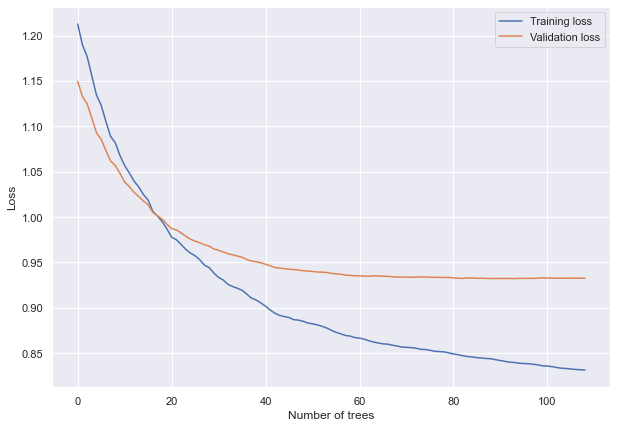

In [147]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

## Create submission

In [148]:
predictions = model.predict(test_X)
submission = pd.DataFrame({"ID": test_df.index, "item_cnt_month": predictions.clip(0,20)})

print(submission.info())
print(submission.nunique())
submission.to_csv('submission.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 2.5 MB
None
ID                214200
item_cnt_month    180484
dtype: int64


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

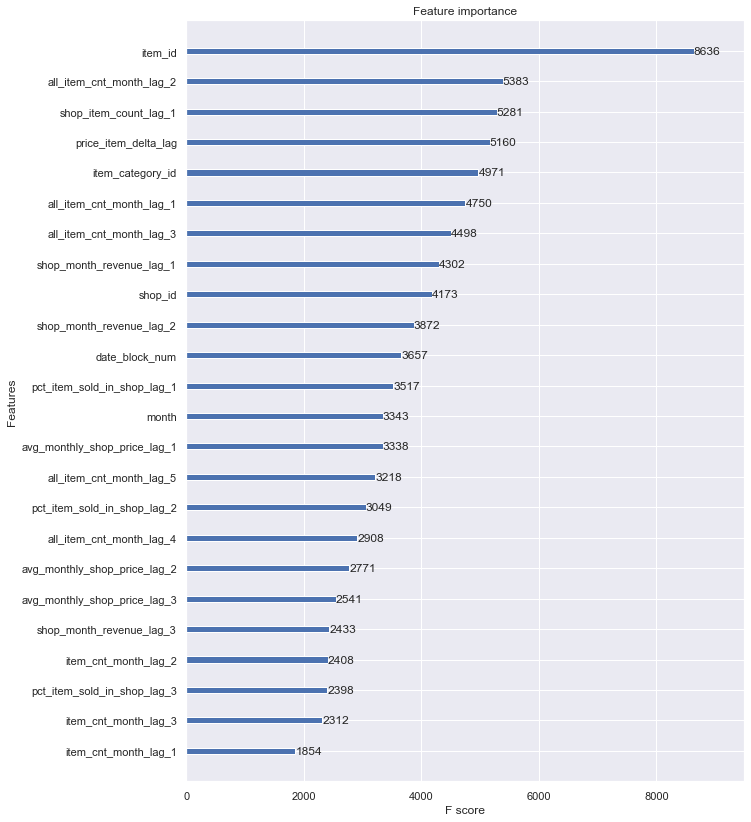

In [149]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))